Loading the data for each year and using the ex9 hypercolumn


## 1. Setup

### 1.1 Install dependencies

Please re-run this as we now need another package (for downloading the data).

In [ ]:
'''import sys
!{sys.executable} -m pip install torch torchvision
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tqdm                      # this gives us a pretty progress bar

# for downloading files from Google drive
!{sys.executable} -m pip install gdown
!pip install rasterio'''

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 906.5 MB 24 kB/s /s eta 0:00:01     |███████████████                 | 427.7 MB 1.9 MB/s eta 0:04:14   | 556.9 MB 3.7 MB/s eta 0:01:35��████████▏         | 628.1 MB 1.8 MB/s eta 0:02:32  |███████████████████████▏        | 655.1 MB 2.1 MB/s eta 0:02:01██████        | 680.9 MB 2.1 MB/s eta 0:01:48
     |████████████████████████████████| 7.2 MB 126.1 MB/s eta 0:00:01
     |████████████████████████████████| 188.7 MB 101.8 MB/s eta 0:00:01
     |████████████████████████████████| 21.1 MB 34.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 57.2 MB/s eta 0:00:01
     |████████████████████████████████| 13.8 MB 75.7 MB/s eta 0:00:01
     |████████████████████████████████| 207.5 MB 63.3 MB/s eta 0:00:01
     |████████████████████████████████| 363.4 MB 11 kB/s s eta 0:00:012
     |████████████████████████████████| 127.9 MB 3.0 MB/s eta 0:00:0101    |███████████████

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


### 1.2 Check if GPU available

This is even more important for semantic segmentation, as our models and data tensors are going to be significantly larger.

Run the following code block and proceed if the response is `True`. Else see an instructor.

In [2]:
import torch

print(torch.cuda.is_available())
import torch
print(torch.__version__)


False
2.5.1+cu124


### 1.3 Random seed

In [ ]:
seed = 323444           # the seed value used to initialise the random number generator of PyTorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## 2. Dataset


In [ ]:
#import zipfile
#with zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/Landcover_Greenland.zip", 'r') as zip_ref:
 #   zip_ref.extractall()

In [ ]:
import rasterio

#with rasterio.open('/content/images/train/2014/tile_0_0_1.tif') as src:
 #   print("Shape (Height, Width):", src.height, src.width)
  #  print("Number of bands:", src.count)


Shape (Height, Width): 128 128
Number of bands: 7


In [ ]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image

import os
import glob
import rasterio
import numpy as np

class GreenlandData(Dataset):
  LABEL_CLASSES = (
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
  )

  def __init__(self, year=2014, transforms=None):
      self.transforms = transforms

      # prepare data
      self.data = []  # list of tuples of (image path, label path, name)
      if year == 2023:
          files_list = sorted(os.listdir('images/test/2023'))
          for file_name in files_list:
              imgName = os.path.join('images/test/2023/',file_name)
              labelName = os.path.join('labels/test/',file_name)
              self.data.append((
                    imgName,
                    labelName,
                    file_name
                ))
      else:
          files_list = sorted(os.listdir(f'images/train/{str(year)}'))
          for file_name in files_list:
              imgName = os.path.join(f'images/train/{str(year)}',file_name)
              labelName = os.path.join('labels/train/',file_name)
              self.data.append((
                    imgName,
                    labelName,
                    file_name
                ))


  def __len__(self):
        return len(self.data)


  def __getitem__(self, x):
      imgName, labelName, fileName = self.data[x]
      with rasterio.open(imgName) as src:
          # Read the RGB bands (3, 2, 1)
          rgb = np.dstack([src.read(3), src.read(2), src.read(1)])
          # Normalize RGB for better visualization
          rgb = rgb.astype(float)
          if rgb.max() - rgb.min() != 0:
            #print('min:',rgb.min())
            #print('max:',rgb.max())
            #print(fileName)
            rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())

      if self.transforms is not None:
          rgb = self.transforms(rgb)

      with rasterio.open(labelName) as lbl_src:
          labels = lbl_src.read(1)  # Read the first band which contains the labels
      return rgb, labels, fileName

dataset of length 1500


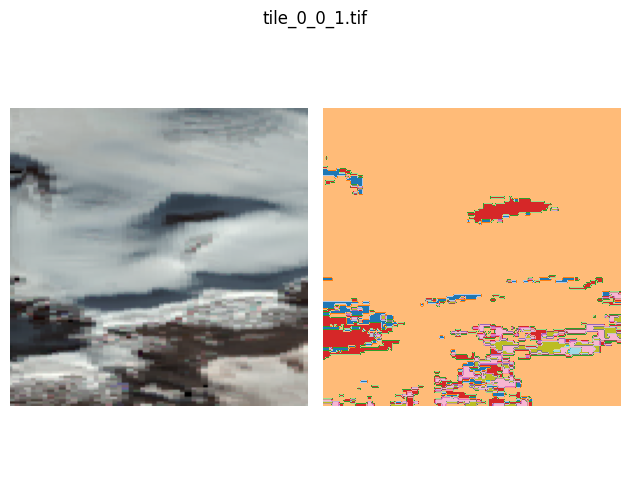

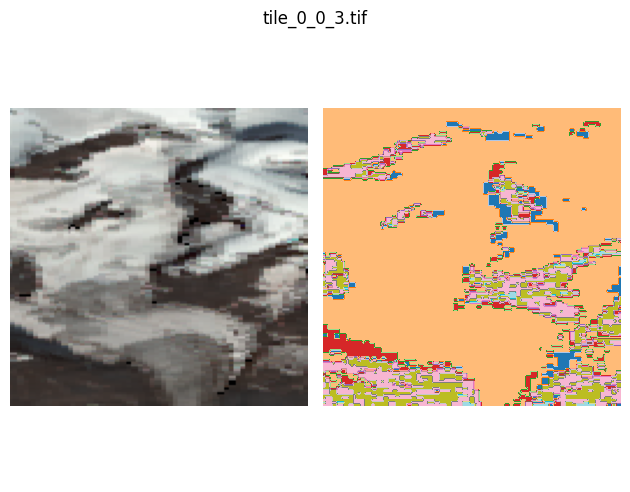

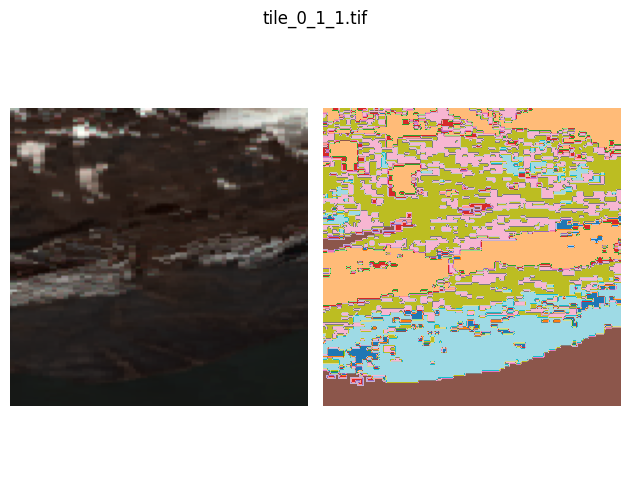

In [ ]:
import matplotlib.pyplot as plt
dataset = GreenlandData()
print(f"dataset of length {len(dataset)}")
# Labels as categories
label_names = [
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
    ]

from ipywidgets import interact
#@interact(idx=range(len(dataset)))
#def plot_sample(idx=0):
for idx in range(3):
    img,label, name = dataset[idx]
    plt.figure()
    plt.axis('off')
    plt.title(name)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='tab20', vmin=0, vmax=len(label_names) - 1)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Let's visualise some images.

## 3. Model

Now let's define our semantic segmentation model! Technically, the model must produce an output that is exactly the same size as its input in space. As stated above we shall use a [Hypercolumn](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Hariharan_Hypercolumns_for_Object_2015_CVPR_paper.pdf) for this task. This is a _Fully Convolutional Network_ (FCN), which means that it does not use a single fully-connected layer, but always preserves some notion of space (so it can use convolutions, pooling, ReLU, etc.). The nice property of FCNs is that they can accept any spatial input of sufficient size and can scale up to the limits of the GPU memory.

A Hypercolumn basically performs downsampling via convolutions, poolings, etc., like you have been doing in Exercise 6 for image classification. However, unlike a classifier, it keeps every intermediate output, upsamples (interpolates) them to the original image's size, stacks them together to a large tensor (a hypercolumn) and uses this to perform pixel-wise classification:

![Hypercolumn](https://www.researchgate.net/profile/Devis-Tuia/publication/323273293/figure/fig3/AS:614258178027521@1523461970498/Hypercolumn-based-architecture-used-in-all-our-experiments-Note-that-all-the-layers-are.png)
Image source: Marcos, D., Volpi, M., Kellenberger, B. and Tuia, D., 2018. Land cover mapping at very high resolution with rotation equivariant CNNs: Towards small yet accurate models. ISPRS journal of photogrammetry and remote sensing, 145, pp.96-107.


Let's implement a Hypercolumn with the following architecture:
1. BLOCK 1:
    1. 2D convolution, 32 kernels of size 5x5, stride 4, zero-padding 0
    2. 2D max pool, kernel size 2x2, stride 1
    2. Batch Normalisation
    3. ReLU
2. BLOCK 2:
    1. 2D convolution, 64 kernels of size 5x5, stride 4, zero-padding 0
    2. 2D max pool, kernel size 2x2, stride 1
    2. Batch Normalisation
    3. ReLU
3. BLOCK 3:
    1. 2D convolution, 128 kernels of size 5x5, stride 2, zero-padding 0
    2. 2D max pool, kernel size 2x2, stride 1
    2. Batch Normalisation
    3. ReLU
4. BLOCK 4:
    1. 2D convolution, 256 kernels of size 3x3, stride 1, zero-padding 0
    2. 2D max pool, kernel size 2x2, stride 1
    2. Batch Normalisation
    3. ReLU
5. HYPERCOLUMN: here you do the following:
    1. Take all outputs of the input and BLOCKs 1, 2, 3 and 4 (after the ReLU)
    2. Interpolate them to the original input's spatial size (tip: use an instance of [torch.nn.Upsample](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html))
    3. Concatenate them together (tip: `torch.cat((tensor1, tensor2, ...), dim=1))
6. FINAL BLOCK: this works on the output of 5. HYPERCOLUMN:
    1. 2D convolution, 256 kernels of size 1x1, stride 1, zero-padding 0
    2. Batch Normalisation
    3. ReLU
    4. 2D convolution, 6 kernels of size 1x1, stride 1, zero-padding 0 (output of model)

In [ ]:
import torch.nn as nn


class Hypercolumn(nn.Module):

    def __init__(self):
        super(Hypercolumn, self).__init__()

        #TODO: define your architecture and forward pass here
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True)
        )
        self.final = nn.Sequential(
            nn.Conv2d(483, 256, kernel_size=1, stride=1),           # 3 (input) + 32 + 64 + 128 + 256 = 487
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 7, kernel_size=1, stride=1)
        )


    def forward(self, x):
        #TODO
        upsample = nn.Upsample(size=(x.size(2), x.size(3)))
        x1 = self.block1(x)
        x2 = self.block2(x1)
        x3 = self.block3(x2)
        x4 = self.block4(x3)

        hypercol = torch.cat(
            (x, upsample(x1), upsample(x2), upsample(x3), upsample(x4)),
            dim=1
        )
        return self.final(hypercol)

Let's test it!

In [ ]:
from torch.utils.data import DataLoader
batch_size=3
dataset_train = GreenlandData(year=2014)
dataloader_train = DataLoader(GreenlandData(year=2014), batch_size=batch_size, num_workers=1)
model = Hypercolumn()

data, _ ,__= iter(dataloader_train).__next__()
print("Original data shape:", data.shape)

# Convert to float32 if needed
data = data.float()

# Ensure the shape is [batch_size, channels, height, width]
if data.ndim == 4 and data.shape[-1] != data.shape[1]:  # Likely [batch_size, height, width, channels]
    data = data.permute(0, 3, 1, 2)  # Rearrange to [batch_size, channels, height, width]

print("Adjusted data shape:", data.shape)
pred = model(data)

assert pred.size(1) == len(dataset_train.LABEL_CLASSES), f'ERROR: invalid number of model output channels (should be # classes {len(dataset_train.LABEL_CLASSES)}, got {pred.size(1)})'
assert pred.size(2) == data.size(2), f'ERROR: invalid spatial height of model output (should be {data.size(2)}, got {pred.size(2)})'
assert pred.size(3) == data.size(3), f'ERROR: invalid spatial width of model output (should be {data.size(3)}, got {pred.size(3)})'

0.0
53332.0
0.0
53703.0
5791.0
44871.0
6598.0
28276.0
6403.5
36005.5
0.0
37510.0
Original data shape: torch.Size([3, 128, 128, 3])
Adjusted data shape: torch.Size([3, 3, 128, 128])


In [ ]:
data, target ,__= iter(dataloader_train).__next__()
print("Original label shape:", target.shape)

target = target.long()

    # Ensure the shape is [batch_size, channels, height, width]
if target.ndim == 4 and target.shape[-1] != target.shape[1]:  # Likely [batch_size, height, width, channels]
    target = target.permute(0, 3, 1, 2)  # Rearrange to [batch_size, channels, height, width]

print("Adjusted target shape:", target.shape)

Original label shape: torch.Size([3, 128, 128])
Adjusted target shape: torch.Size([3, 128, 128])


## 4. Model training

All the rest is exactly the same principle as for the image classification part!
Hence, what you can do here is to simply copy-paste all your code cells from Section 4 ("Implement training routine") of the previous exercise.

In [ ]:
#TODO
criterion = nn.CrossEntropyLoss()

In [ ]:
from torch.optim import SGD

def setup_optimiser(model, learning_rate, weight_decay):
  return SGD(
    model.parameters(),
    learning_rate,
    weight_decay
  )

In [ ]:
from tqdm.notebook import trange      # pretty progress bar


def train_epoch(data_loader, model, optimiser, device):

  # set model to training mode. This is important because some layers behave differently during training and testing
  model.train(True)
  model.to(device)

  # stats
  loss_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target, img_name) in enumerate(data_loader):

    #TODO: implement the training step here. Check the introductory slides if you need help.

    data = data.float()

    # Ensure the shape is [batch_size, channels, height, width]
    if data.ndim == 4 and data.shape[-1] != data.shape[1]:  # Likely [batch_size, height, width, channels]
        data = data.permute(0, 3, 1, 2)  # Rearrange to [batch_size, channels, height, width]

    target = target.long()

    # Ensure the shape is [batch_size, channels, height, width]
    if target.ndim == 4 and target.shape[-1] != target.shape[1]:  # Likely [batch_size, height, width, channels]
        target = target.permute(0, 3, 1, 2)  # Rearrange to [batch_size, channels, height, width]
    # put data and target onto correct device
    data, target = data.to(device), target.to(device)

    # reset gradients
    optimiser.zero_grad()

    # forward pass
    pred = model(data)

    # loss
    loss = criterion(pred, target)

    # backward pass
    loss.backward()

    # parameter update
    optimiser.step()

    #print loss
    #print('loss:', loss.item())
    # stats update
    loss_total += loss.item()
    oa_total += torch.mean((pred.argmax(1) == target).float()).item()

    # format progress bar
    pBar.set_description('Loss: {:.2f}, OA: {:.2f}'.format(
      loss_total/(idx+1),
      100 * oa_total/(idx+1)
    ))
    pBar.update(1)

  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  oa_total /= len(data_loader)

  return model, loss_total, oa_total

In [ ]:
def validate_epoch(data_loader, model, device):       # note: no optimiser needed

  # set model to evaluation mode
  model.train(False)
  model.to(device)

  # stats
  loss_total = 0.0
  oa_total = 0.0

  # iterate over dataset
  pBar = trange(len(data_loader))
  for idx, (data, target, img_name) in enumerate(data_loader):
    with torch.no_grad():

      #TODO: likewise, implement the validation routine. This is very similar, but not identical, to the training steps.
      data = data.float()

      # Ensure the shape is [batch_size, channels, height, width]
      if data.ndim == 4 and data.shape[-1] != data.shape[1]:  # Likely [batch_size, height, width, channels]
          data = data.permute(0, 3, 1, 2)  # Rearrange to [batch_size, channels, height, width]\
      target = target.long()

      # Ensure the shape is [batch_size, channels, height, width]
      if target.ndim == 4 and target.shape[-1] != target.shape[1]:  # Likely [batch_size, height, width, channels]
          target = target.permute(0, 3, 1, 2)  # Rearrange to [batch_size, channels, height, width]
      # put data and target onto correct device
      data, target = data.to(device), target.to(device)

      # forward pass
      pred = model(data)

      # loss
      loss = criterion(pred, target)

      # stats update
      loss_total += loss.item()
      oa_total += torch.mean((pred.argmax(1) == target).float()).item()

      # format progress bar
      pBar.set_description('Loss: {:.2f}, OA: {:.2f}'.format(
        loss_total/(idx+1),
        100 * oa_total/(idx+1)
      ))
      pBar.update(1)

  pBar.close()

  # normalise stats
  loss_total /= len(data_loader)
  oa_total /= len(data_loader)

  return loss_total, oa_total

The rest (Section 5 and later from Exercise 7) is also the same, but we change the model name and parameters a bit here, which is why these code blocks are given to you below.

In [ ]:
import glob

os.makedirs('cnn_states/Hypercolumn', exist_ok=True)

def load_model(epoch='latest'):
  model = Hypercolumn()
  modelStates = glob.glob('cnn_states/Hypercolumn/*.pth')
  if len(modelStates) and (epoch == 'latest' or epoch > 0):
    modelStates = [int(m.replace('cnn_states/Hypercolumn/','').replace('.pth', '')) for m in modelStates]
    if epoch == 'latest':
      epoch = max(modelStates)
    stateDict = torch.load(open(f'cnn_states/Hypercolumn/{epoch}.pth', 'rb'), map_location='cpu')
    model.load_state_dict(stateDict)
  else:
    # fresh model
    epoch = 0
  return model, epoch


def save_model(model, epoch):
  torch.save(model.state_dict(), open(f'cnn_states/Hypercolumn/{epoch}.pth', 'wb'))

In [ ]:
# define hyperparameters
device = 'cuda'
start_epoch = 0        # set to 0 to start from scratch again or to 'latest' to continue training from saved checkpoint
batch_size = 2
learning_rate = 0.1
weight_decay = 0.001
num_epochs = 10



# initialise data loaders
dl_train = DataLoader(GreenlandData(year=2014), batch_size=batch_size,shuffle=True, num_workers=1)
dl_val = DataLoader(GreenlandData(year=2015), batch_size=batch_size,shuffle=True, num_workers=1)

# load model
model, epoch = load_model(epoch=start_epoch)
optim = setup_optimiser(model, learning_rate, weight_decay)

# do epochs
while epoch < num_epochs:

  # training
  model, loss_train, oa_train = train_epoch(dl_train, model, optim, device)

  # validation
  loss_val, oa_val = validate_epoch(dl_val, model, device)

  # print stats
  print('[Ep. {}/{}] Loss train: {:.2f}, val: {:.2f}; OA train: {:.2f}, val: {:.2f}'.format(
      epoch+1, num_epochs,
      loss_train, loss_val,
      100*oa_train, 100*oa_val
  ))

  # save model
  epoch += 1
  save_model(model, epoch)

  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 1/10] Loss train: 1.71, val: 1.30; OA train: 35.77, val: 50.80


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 2/10] Loss train: 1.49, val: 1.45; OA train: 43.11, val: 45.02


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 3/10] Loss train: 1.40, val: 1.19; OA train: 48.09, val: 58.48


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 4/10] Loss train: 1.34, val: 1.21; OA train: 50.17, val: 57.21


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 5/10] Loss train: 1.30, val: 1.16; OA train: 52.14, val: 60.48


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 6/10] Loss train: 1.26, val: 1.31; OA train: 53.55, val: 50.50


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 7/10] Loss train: 1.23, val: 1.36; OA train: 54.66, val: 51.25


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 8/10] Loss train: 1.19, val: 1.37; OA train: 56.12, val: 45.66


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 9/10] Loss train: 1.17, val: 1.29; OA train: 57.30, val: 52.99


  0%|          | 0/750 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

[Ep. 10/10] Loss train: 1.15, val: 1.23; OA train: 58.07, val: 53.22


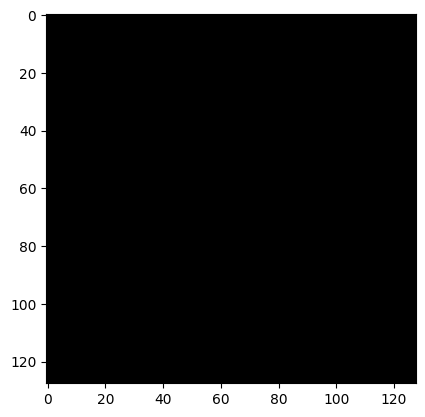

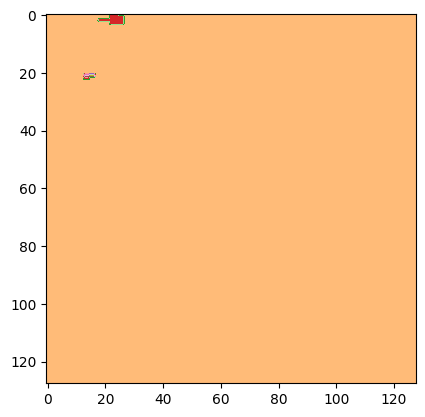

In [ ]:
with rasterio.open('/content/images/train/2014/tile_159_2_2.tif') as src:
        # Read the RGB bands (3, 2, 1)
      rgb = np.dstack([src.read(3), src.read(2), src.read(1)])
        # Normalize RGB for better visualization
      rgb = rgb.astype(float)
      #rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())
      plt.figure()
      plt.imshow(rgb)

with rasterio.open('/content/labels/train/tile_159_2_2.tif') as lbl_src:
      labels = lbl_src.read(1)
      plt.figure()
      plt.imshow(labels, cmap='tab20', vmin=0, vmax=len(label_names) - 1)

## 5. Model validation

Like in Exercise 7 we could do a final accuracy evaluation now. We don't have access to the Vaihingen dataset's test image labels, since these are hidden on an official Web evaluation server (the Vaihingen dataset was at some point a contest where people could submit their scores and compete against each other!).

But, we can do something else that we could not do in Exercise 7: visualise our results! Our model provides segmentation masks after all… So let's do this!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualize(dataLoader, epochs, numImages=5):
  models = [load_model(e)[0] for e in epochs]
  numModels = len(models)
  for idx, (data, labels) in enumerate(dataLoader):
    if idx == numImages:
      break

    _, ax = plt.subplots(nrows=1, ncols=numModels+1, figsize = (20, 15))

    # plot ground truth
    ax[0].imshow(labels[0,...].cpu().numpy())
    ax[0].axis('off')
    if idx == 0:
      ax[0].set_title('Ground Truth')

    for mIdx, model in enumerate(models):
      model = model.to(device)
      with torch.no_grad():
        pred = model(data.to(device))

        # get the label (i.e., the maximum position for each pixel along the class dimension)
        yhat = torch.argmax(pred, dim=1)

        # plot model predictions
        ax[mIdx+1].imshow(yhat[0,...].cpu().numpy())
        ax[mIdx+1].axis('off')
        if idx == 0:
          ax[mIdx+1].set_title(f'Epoch {epochs[mIdx]}')


# visualize predictions for a number of epochs
dl_val_single = load_dataloader(1, 'val')

# load model states at different epochs
epochs = [0, 1, 5, 'latest']                                          #TODO: modify this vector according to your wishes, resp. for how many model states you have trained

visualize(dl_val_single, epochs, numImages=5)